In [1]:
import csv
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.model_selection import KFold

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0 1"

In [3]:
# from keras.models import Sequential
# from keras.layers.embeddings import Embedding
# from keras.layers.recurrent import GRU
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Dense, LSTM, Bidirectional
# import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,GRU,Dense,LSTM,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# # Include this block so that keras 
# # would not use up all the GPU memory.
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [5]:
# import tensorflow as tf
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/fyp5/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fyp5/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fyp5/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
datafiles_path = './data/drug_feature_content.csv'
data_files = pd.read_csv(datafiles_path)

In [9]:
data_files.head()

,neutral_citation,trial_id,remorse,self_consume,controlled_delivery,testimony,good_character,guilty_plea_stage,refugee,bail,street,persistent,international,content
0,[2018] hkcfi 2360,2160,0,0,0,0,0,0,0,0,0,1,1,## HKSAR v. CHUNG YIU LAM [2018] HKCFI 2360; ...
1,[2013] hkcfi 1943,1951,0,0,0,0,0,1,0,0,0,0,1,"## HKSAR v. KIWAMBA, WATENDE SUDI [2013] HKCF..."
2,[2009] hkdc 1600,872,0,0,0,0,0,1,0,0,0,0,0,## HKSAR v. YAU SUET YIM [2009] HKDC 1600; DC...
3,[2010] hkdc 1392,1742,1,0,0,0,0,1,0,0,0,0,0,* * * ## HKSAR v. MA KWOK WAI [2010] HKDC 13...
4,[2009] hkdc 1759,725,0,0,0,0,0,1,0,0,0,0,0,## HKSAR v. NAM HOI CHOW [2009] HKDC 1759; DC...


In [10]:
datas_X = data_files['content']


datas_Y = data_files.drop(['neutral_citation'], axis = 1)
datas_Y = datas_Y.drop(['content'], axis = 1)
datas_Y = datas_Y.drop(['trial_id'], axis = 1)
datas_Y = datas_Y.drop(['guilty_plea_stage'], axis = 1)
datas_Y = datas_Y.drop(['street'], axis = 1)

In [11]:
datas_X.head()

0    ##  HKSAR v. CHUNG YIU LAM [2018] HKCFI 2360; ...
1    ##  HKSAR v. KIWAMBA, WATENDE SUDI [2013] HKCF...
2    ##  HKSAR v. YAU SUET YIM [2009] HKDC 1600; DC...
3    * * *  ##  HKSAR v. MA KWOK WAI [2010] HKDC 13...
4    ##  HKSAR v. NAM HOI CHOW [2009] HKDC 1759; DC...
Name: content, dtype: object

In [12]:
datas_Y.head()

,remorse,self_consume,controlled_delivery,testimony,good_character,refugee,bail,persistent,international
0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


In [13]:
data_example = datas_X[0]
data_example

'##  HKSAR v. CHUNG YIU LAM [2018] HKCFI 2360; HCCC 36/2018 (16 August 2018)  HCCC 36/2018  [2018] HKCFI 2360  IN THE HIGH COURT OF THE  HONG KONG SPECIAL ADMINISTRATIVE REGION  COURT OF FIRST INSTANCE  CRIMINAL CASE NO 36 OF 2018  \\-----------------  HKSAR   v   CHUNG Yiu-lam      \\------------------  Before: Hon Yau J   Date: 16 August 2018 at 3.13 pm   Present: Mr Paul Leung, on fiat, for HKSAR   Mr Phil Chau, instructed by Cheung & Liu, assigned by DLA, for the accused   Offence: Trafficking in a dangerous drug (販運危險藥物)       \\-------------------------------------------------  Transcript of the Audio Recording  of the Sentence in the above Case  \\-------------------------------------------------  COURT:  The defendant, Mr Chung Yiu-lam, faces one count of trafficking in a dangerous drug contrary to section 4(1)(a) and (3) of the Dangerous Drugs Ordinance, Chapter 134. The particulars of the offence are that the defendant, on the 18th day of September 2014, in Hong Kong, togethe

In [14]:
type(data_example)

str

In [15]:
#Clean up the data

#Function to clean up data
#•Only take characters inside A-Za-z0-9
#•remove stop words
#•lemmatize

In [16]:
#stopwords = []
#with open("C:\\HKRA\\data\\data extracting\\stop_words_eng.txt", "r") as f:  # 打开文件
#    for line in f.readlines():
#        line = line.strip('\n')  #去掉列表中每一个元素的换行符
#        stopwords.append(line)
    

In [17]:
#a = set((stopwords))
#a

In [18]:
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z ]+")
#stop_words = set(stopwords)
stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = None):
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if w not in stop_words:
                filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

In [19]:
totalX = []
totalY = np.array(datas_Y)
for i, doc in enumerate(datas_X):
    #直接在这里去除\n，防止\n可能会让两句话连接处的两个单词连在一起
    doc = doc.replace("\n"," ")
    totalX.append(cleanUpSentence(doc, stop_words))

In [20]:
# data_example

In [21]:
print(totalX[1])

hksar v kiwamba watende sudi hkcfi hccc october hccc high court hong kong special administrative region court first instance criminal case hksar v kiwamba watende sudi dhcj mcmahon date october present mr p j power ddpp ag department justice hksar mr john p mcnamara instructed simon si co assigned dla accused offence trafficking dangerous drug transcript audio recording sentence case court defendant pleaded guilty eastern magistracy offence trafficking gramme heroin ha committed court sentence march year defendant yearold tanzanian national arrived hong kong international airport flight kenya concealed within body packet containing total charged drug starting point sentence take quantity heroin year imprisonment enhance starting point year imprisonment reflect international element offence substantive mitigation defendant plea guilty reflect reduce sentence one year month imprisonment


In [22]:
# print(totalY[0])

In [23]:
# len(totalY)

In [24]:
xLengths = [len(word_tokenize(x)) for x in totalX]
h = sorted(xLengths)  #sorted lengths 升序 第一个最小
maxLength =h[len(h)-1]
print("max input length is: ",maxLength)

max input length is:  2422


In [25]:
maxLength = h[int(len(h) * 0.70)]
print("70% cover input sequence length up to",maxLength)

70% cover input sequence length up to 485


In [26]:
#给每个句子的词标上id
max_vocab_size = 30000
input_tokenizer = Tokenizer(max_vocab_size)
input_tokenizer.fit_on_texts(totalX)
input_vocab_size = len(input_tokenizer.word_index) + 1
print("input_vocab_size:",input_vocab_size)
#pre-padding and pre-truncating
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxLength))

input_vocab_size: 14556


In [27]:
word_index = input_tokenizer.word_index

In [28]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('./embedding/GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,max_vocab_size)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
count = 0
for word, i in word_index.items():
    if i>=max_vocab_size:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)


In [29]:
#Create Keras model
#num_categories 总标签数
num_categories = len(totalY[0])
num_categories
totalX.shape[0]

2545

In [30]:
prediction = []
prediction_index = []
early_stopping = EarlyStopping(patience=5)
histories = []
kf = KFold(n_splits=5)

strategy = tf.distribute.MirroredStrategy()

for train_index, test_index in kf.split(totalX):
    with strategy.scope():
        model = Sequential()
        model.add(Embedding(input_vocab_size, EMBEDDING_DIM,input_length = maxLength, 
                            weights=[embedding_matrix],
                            trainable=False))
        # model.add(Embedding(input_vocab_size, embedding_dim,input_length = maxLength))
        # model.add(GRU(256, dropout=0.5, return_sequences=True))
        # model.add(GRU(256, dropout=0.5))
        model.add(Bidirectional(LSTM(256, dropout=0.5, return_sequences=True)))
        model.add(Bidirectional(LSTM(256, dropout=0.5)))
        model.add(Dense(num_categories, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])    

    
    trainX = totalX[train_index]
    trainY = totalY[train_index]
    histories.append(model.fit(trainX, trainY, validation_split=0.1, batch_size=128, epochs=50))
    testX = totalX[test_index]
    testY = totalY[test_index]
    print(model.evaluate(testX, testY))
    prediction_index.extend(data_files.loc[test_index]['trial_id'].values.tolist())
    prediction.extend(model.predict(testX))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/50
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to 

15/15 [==============================] - 3s 192ms/step - loss: 0.0808 - binary_accuracy: 0.9756 - val_loss: 0.2057 - val_binary_accuracy: 0.9515
Epoch 40/50
15/15 [==============================] - 3s 200ms/step - loss: 0.0781 - binary_accuracy: 0.9752 - val_loss: 0.2005 - val_binary_accuracy: 0.9542
Epoch 41/50
15/15 [==============================] - 3s 188ms/step - loss: 0.0738 - binary_accuracy: 0.9767 - val_loss: 0.2196 - val_binary_accuracy: 0.9510
Epoch 42/50
15/15 [==============================] - 3s 190ms/step - loss: 0.0746 - binary_accuracy: 0.9770 - val_loss: 0.2001 - val_binary_accuracy: 0.9559
Epoch 43/50
15/15 [==============================] - 3s 188ms/step - loss: 0.0755 - binary_accuracy: 0.9756 - val_loss: 0.1970 - val_binary_accuracy: 0.9521
Epoch 44/50
15/15 [==============================] - 3s 201ms/step - loss: 0.0704 - binary_accuracy: 0.9775 - val_loss: 0.2171 - val_binary_accuracy: 0.9483
Epoch 45/50
15/15 [==============================] - 3s 198ms/step - l

15/15 [==============================] - 3s 206ms/step - loss: 0.0998 - binary_accuracy: 0.9703 - val_loss: 0.2149 - val_binary_accuracy: 0.9483
Epoch 40/50
15/15 [==============================] - 3s 205ms/step - loss: 0.0954 - binary_accuracy: 0.9709 - val_loss: 0.2183 - val_binary_accuracy: 0.9472
Epoch 41/50
15/15 [==============================] - 3s 201ms/step - loss: 0.0928 - binary_accuracy: 0.9712 - val_loss: 0.2161 - val_binary_accuracy: 0.9483
Epoch 42/50
15/15 [==============================] - 3s 205ms/step - loss: 0.0958 - binary_accuracy: 0.9702 - val_loss: 0.2250 - val_binary_accuracy: 0.9466
Epoch 43/50
15/15 [==============================] - 3s 202ms/step - loss: 0.0915 - binary_accuracy: 0.9728 - val_loss: 0.2166 - val_binary_accuracy: 0.9493
Epoch 44/50
15/15 [==============================] - 3s 208ms/step - loss: 0.0882 - binary_accuracy: 0.9724 - val_loss: 0.2139 - val_binary_accuracy: 0.9504
Epoch 45/50
15/15 [==============================] - 3s 200ms/step - l

15/15 [==============================] - 3s 202ms/step - loss: 0.1313 - binary_accuracy: 0.9546 - val_loss: 0.2248 - val_binary_accuracy: 0.9336
Epoch 40/50
15/15 [==============================] - 3s 204ms/step - loss: 0.1260 - binary_accuracy: 0.9575 - val_loss: 0.2289 - val_binary_accuracy: 0.9319
Epoch 41/50
15/15 [==============================] - 3s 205ms/step - loss: 0.1206 - binary_accuracy: 0.9597 - val_loss: 0.2389 - val_binary_accuracy: 0.9341
Epoch 42/50
15/15 [==============================] - 3s 206ms/step - loss: 0.1169 - binary_accuracy: 0.9619 - val_loss: 0.2395 - val_binary_accuracy: 0.9303
Epoch 43/50
15/15 [==============================] - 3s 207ms/step - loss: 0.1123 - binary_accuracy: 0.9652 - val_loss: 0.2203 - val_binary_accuracy: 0.9406
Epoch 44/50
15/15 [==============================] - 3s 208ms/step - loss: 0.1113 - binary_accuracy: 0.9659 - val_loss: 0.2263 - val_binary_accuracy: 0.9352
Epoch 45/50
15/15 [==============================] - 3s 207ms/step - l

15/15 [==============================] - 3s 206ms/step - loss: 0.0900 - binary_accuracy: 0.9725 - val_loss: 0.1976 - val_binary_accuracy: 0.9477
Epoch 40/50
15/15 [==============================] - 3s 210ms/step - loss: 0.0838 - binary_accuracy: 0.9751 - val_loss: 0.1954 - val_binary_accuracy: 0.9499
Epoch 41/50
15/15 [==============================] - 3s 208ms/step - loss: 0.0828 - binary_accuracy: 0.9753 - val_loss: 0.1988 - val_binary_accuracy: 0.9521
Epoch 42/50
15/15 [==============================] - 3s 204ms/step - loss: 0.0811 - binary_accuracy: 0.9747 - val_loss: 0.1919 - val_binary_accuracy: 0.9510
Epoch 43/50
15/15 [==============================] - 3s 206ms/step - loss: 0.0902 - binary_accuracy: 0.9713 - val_loss: 0.2315 - val_binary_accuracy: 0.9483
Epoch 44/50
15/15 [==============================] - 3s 210ms/step - loss: 0.0911 - binary_accuracy: 0.9725 - val_loss: 0.1936 - val_binary_accuracy: 0.9548
Epoch 45/50
15/15 [==============================] - 3s 213ms/step - l

15/15 [==============================] - 3s 206ms/step - loss: 0.0987 - binary_accuracy: 0.9716 - val_loss: 0.1588 - val_binary_accuracy: 0.9581
Epoch 40/50
15/15 [==============================] - 3s 205ms/step - loss: 0.0960 - binary_accuracy: 0.9709 - val_loss: 0.1638 - val_binary_accuracy: 0.9564
Epoch 41/50
15/15 [==============================] - 3s 210ms/step - loss: 0.0936 - binary_accuracy: 0.9724 - val_loss: 0.1680 - val_binary_accuracy: 0.9553
Epoch 42/50
15/15 [==============================] - 3s 211ms/step - loss: 0.0920 - binary_accuracy: 0.9726 - val_loss: 0.1571 - val_binary_accuracy: 0.9586
Epoch 43/50
15/15 [==============================] - 3s 209ms/step - loss: 0.0948 - binary_accuracy: 0.9723 - val_loss: 0.1653 - val_binary_accuracy: 0.9553
Epoch 44/50
15/15 [==============================] - 3s 211ms/step - loss: 0.0941 - binary_accuracy: 0.9728 - val_loss: 0.1638 - val_binary_accuracy: 0.9597
Epoch 45/50
15/15 [==============================] - 3s 215ms/step - l

In [31]:
# import csv
# with open('extracted_factors_gru.csv', 'w') as ofile:
#     csv_writer = csv.writer(ofile, delimiter=',', quotechar='"')
#     csv_writer.writerow(['trial_id'] + list(data_files.columns)[2:13])
#     for idx, predict in zip(prediction_index, prediction):
#         csv_writer.writerow([idx] + list(predict>0.5))

In [32]:
# for idx, predict in zip(prediction_index, prediction):
#     print(np.where(predict>0.5), 1, 0)
#     break

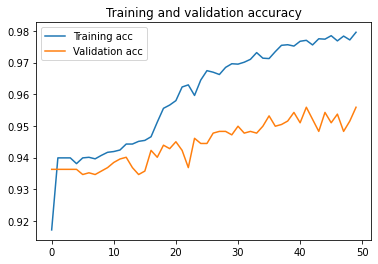

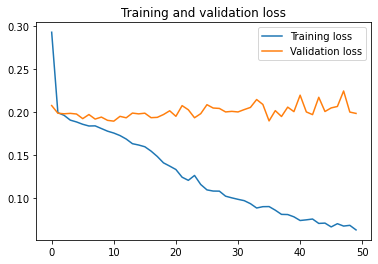

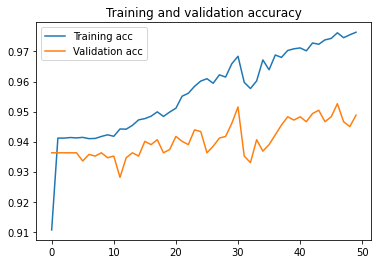

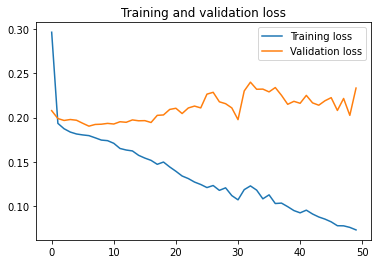

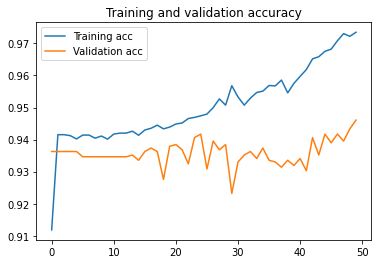

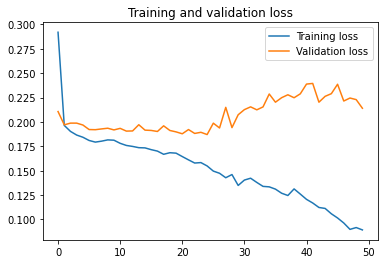

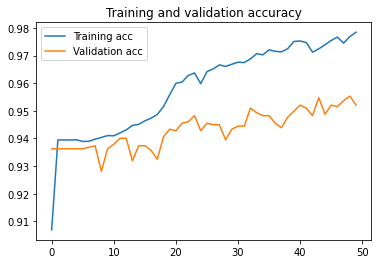

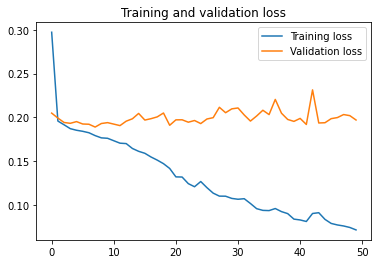

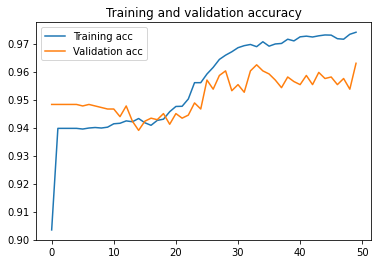

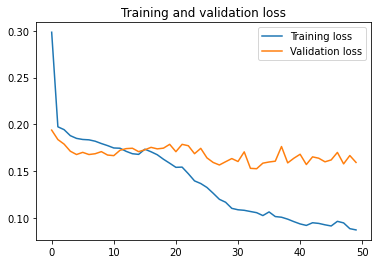

In [33]:
import matplotlib.pyplot as plt


for history in histories:
    
    plt.figure()
    
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss,  label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plt.show()


In [34]:
import csv
with open('extracted_factors_lstm_word2vec.csv', 'w') as ofile:
    csv_writer = csv.writer(ofile, delimiter=',', quotechar='"')
    csv_writer.writerow(['trial_id'] + list(data_files.columns)[2:7] + 
                       list(data_files.columns)[8:10] +
                       list(data_files.columns)[11:13])
    for idx, predict in zip(prediction_index, prediction):
        csv_writer.writerow([idx] + list(predict>0.5))